In [12]:
# Block 1: Imports and Constants
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import os
import warnings

# --- Constants and Parameters ---
# Adjust DATA_FOLDER if your path is different. Assumes it's a subfolder relative to the notebook.
DATA_FOLDER = './round-3-island-data-bottle'
RISK_FREE_RATE = 0.0  # Assuming 0% risk-free rate as none is given
TRADING_DAYS_PER_YEAR = 252 # Common convention, adjust if specified otherwise

# Mapping from competition day to TTE (in days)
DAYS_REMAINING_MAP = {
    0: 7,
    1: 6,
    2: 5,
    # Add more days if your dataset includes them (e.g., 3: 4, 4: 3)
}

# Define Vouchers and their strikes
VOUCHERS = {
    "VOLCANIC_ROCK_VOUCHER_9500": 9500,
    "VOLCANIC_ROCK_VOUCHER_9750": 9750,
    "VOLCANIC_ROCK_VOUCHER_10000": 10000,
    "VOLCANIC_ROCK_VOUCHER_10250": 10250,
    "VOLCANIC_ROCK_VOUCHER_10500": 10500,
}
UNDERLYING = "VOLCANIC_ROCK"

print("Libraries imported and constants defined.")

Libraries imported and constants defined.


In [19]:
# Block 2 (Revised): Define Standalone Helper Functions
import math
import numpy as np
from statistics import NormalDist
from scipy.optimize import brentq # Or use bisection if preferred

# Black-Scholes Price function (using math, NormalDist)
def bs_price(S, K, r, T, sigma):
    """Calculates Black-Scholes price for a European call option."""
    if sigma <= 0 or T <= 0: return max(0.0, S - K * math.exp(-r*T))
    if S <= 0 or K <= 0: return 0.0
    sigma_sqrt_T = sigma * math.sqrt(T)
    if sigma_sqrt_T < 1e-9: return max(0.0, S - K * math.exp(-r*T))

    N = NormalDist().cdf
    try:
        d1 = (math.log(S/K) + (r + 0.5 * (sigma ** 2)) * T) / sigma_sqrt_T
        d2 = d1 - sigma_sqrt_T
        price = S * N(d1) - K * math.exp(-r * T) * N(d2)
        # Ensure price is not negative due to numerical issues
        return max(0.0, price)
    except (ValueError, OverflowError):
        # Fallback to intrinsic value if math error occurs
        return max(0.0, S - K * math.exp(-r*T))

# Implied Volatility function (using bisection - similar to your Trader's version)
def implied_volatility_bisect(S, K, r, T, v_market_price, tol=1e-5, max_iter=100):
    """Calculates implied volatility using bisection method."""
    if T <= 1e-9: return 0.0001 # Avoid division by zero / sqrt(0)
    # Check arbitrage bounds
    intrinsic_value = max(0.0, S - K * math.exp(-r*T))
    if v_market_price < intrinsic_value - tol: return np.nan # Price below intrinsic
    if abs(v_market_price - intrinsic_value) < tol: return 0.0001 # Price is intrinsic -> vol near zero

    # Check upper bound: C <= S
    if v_market_price > S + tol : return np.nan

    sigma_low = 1e-6
    sigma_high = 5.0 # Reasonable upper bound

    try:
        price_low = bs_price(S, K, r, T, sigma_low)
        # Check if market price is lower than price at min volatility
        if v_market_price < price_low : return sigma_low # Cannot go lower

        for _ in range(max_iter):
            sigma_mid = (sigma_low + sigma_high) / 2.0
            if sigma_mid < 1e-7: sigma_mid = 1e-7 # Avoid sigma getting too close to 0 for BS stability

            price_mid = bs_price(S, K, r, T, sigma_mid)

            if abs(price_mid - v_market_price) < tol:
                return sigma_mid
            elif price_mid < v_market_price:
                sigma_low = sigma_mid
            else:
                sigma_high = sigma_mid

            if abs(sigma_high - sigma_low) < tol: # Stop if interval is small enough
                 return (sigma_low + sigma_high) / 2.0

        # If max_iter reached, check if bounds produced price range containing market price
        price_high_check = bs_price(S, K, r, T, sigma_high)
        if price_low <= v_market_price <= price_high_check or price_high_check <= v_market_price <= price_low :
             return (sigma_low + sigma_high) / 2.0 # Return midpoint if bracketed
        else:
             #print(f"IV Warning: Max iter reached, price not bracketed. S={S}, K={K}, T={T}, V={v_market_price}")
             return np.nan # Failed to converge / bracket

    except Exception as e:
        # Catch potential errors during bs calls within loop
        #print(f"Error in IV calculation: S={S}, K={K}, T={T}, V={v_market_price} -> {e}")
        return np.nan

# Delta function (needed later for hedging, good to define now)
def bs_delta(S, K, r, T, sigma):
    """Calculates the Black-Scholes delta for a European call option."""
    if sigma <= 0 or T <= 0: return 1.0 if S > K else 0.0
    if S <= 0 or K <= 0: return 0.0
    sigma_sqrt_T = sigma * math.sqrt(T)
    if sigma_sqrt_T < 1e-9: return 1.0 if S > K else 0.0

    N = NormalDist().cdf
    try:
        d1 = (math.log(S/K) + (r + 0.5 * (sigma ** 2)) * T) / sigma_sqrt_T
        delta_value = N(d1)
        if pd.isna(delta_value): return None
        return max(0.0, min(1.0, delta_value))
    except (ValueError, OverflowError):
        return None

print("Standalone helper functions (bs_price, implied_volatility_bisect, bs_delta) defined.")

Standalone helper functions (bs_price, implied_volatility_bisect, bs_delta) defined.


In [15]:
# Block 3: Data Loading and Initial Processing

all_data = []
# Check which day files exist in the folder
try:
    available_files = [f for f in os.listdir(DATA_FOLDER) if f.startswith('prices_round_3_day_') and f.endswith('.csv')]
    available_days = sorted([int(f.split('_')[-1].split('.')[0]) for f in available_files])
    print(f"Found data files for days: {available_days}")
except FileNotFoundError:
    print(f"Error: Data folder '{DATA_FOLDER}' not found. Please check the path.")
    available_days = [] # Ensure loop doesn't run

if not available_days:
    print("No data files found. Cannot proceed.")
else:
    for day in available_days:
        # Ensure day is in our TTE map
        if day not in DAYS_REMAINING_MAP:
            print(f"Warning: Day {day} found in filename but not in DAYS_REMAINING_MAP. Skipping file.")
            continue

        file_path = os.path.join(DATA_FOLDER, f'prices_round_3_day_{day}.csv')
        print(f"Processing {file_path}...")
        try:
            df_day = pd.read_csv(file_path, sep=';')
            # Ensure timestamp uniqueness if needed (sometimes 0 repeats)
            # df_day['timestamp_unique'] = df_day.groupby('timestamp').cumcount() # Optional helper
            df_day['day'] = day # Add day column for TTE calculation
            all_data.append(df_day)
        except FileNotFoundError:
            print(f"Warning: File not found {file_path}") # Should be caught above, but belt-and-suspenders
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    if not all_data:
        print("Error: No data files were successfully loaded. Exiting.")
        df = pd.DataFrame() # Create empty df to avoid errors later
    else:
        df = pd.concat(all_data, ignore_index=True)
        print(f"Concatenated data shape: {df.shape}")

        # Filter for relevant products
        products_to_keep = [UNDERLYING] + list(VOUCHERS.keys())
        df_filtered = df[df['product'].isin(products_to_keep)].copy()
        print(f"Filtered data shape: {df_filtered.shape}")

        # Calculate TTE (Time To Expiry in years)
        df_filtered['days_remaining'] = df_filtered['day'].map(DAYS_REMAINING_MAP)
        df_filtered['TTE'] = df_filtered['days_remaining'] / TRADING_DAYS_PER_YEAR
        print("Calculated TTE.")

        # Calculate mid_price if it's missing
        if 'mid_price' not in df_filtered.columns or df_filtered['mid_price'].isnull().any():
            if 'ask_price_1' in df_filtered.columns and 'bid_price_1' in df_filtered.columns:
                print("Calculating mid_price from best bid/ask where missing...")
                # Ensure numeric conversion, coercing errors
                ask = pd.to_numeric(df_filtered['ask_price_1'], errors='coerce')
                bid = pd.to_numeric(df_filtered['bid_price_1'], errors='coerce')
                calculated_mid = (ask + bid) / 2
                # Fill missing mid_price only where calculation is valid
                df_filtered['mid_price'] = df_filtered['mid_price'].fillna(calculated_mid)
            else:
                print("Warning: 'mid_price' has NaNs and cannot calculate from bids/asks.")

        # Ensure mid_price is numeric
        df_filtered['mid_price'] = pd.to_numeric(df_filtered['mid_price'], errors='coerce')

        # Drop rows where mid_price is still NaN after calculation/coercion
        initial_rows = len(df_filtered)
        df_filtered.dropna(subset=['mid_price'], inplace=True)
        if initial_rows > len(df_filtered):
             print(f"Dropped {initial_rows - len(df_filtered)} rows due to missing mid_price.")

        print("Initial processing complete.")
        # Display sample of processed data
        # print("\nSample of filtered data with TTE:")
        # print(df_filtered[['day', 'timestamp', 'product', 'mid_price', 'TTE']].head())

# Check if df_filtered exists and has data
if 'df_filtered' not in locals() or df_filtered.empty:
    print("No data available for pivoting.")

Found data files for days: [0, 1, 2]
Processing ./round-3-island-data-bottle/prices_round_3_day_0.csv...
Processing ./round-3-island-data-bottle/prices_round_3_day_1.csv...
Processing ./round-3-island-data-bottle/prices_round_3_day_2.csv...
Concatenated data shape: (420000, 17)
Filtered data shape: (180000, 17)
Calculated TTE.
Initial processing complete.


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


In [16]:
# Block 4: Data Pivoting and Cleaning

if 'df_filtered' in locals() and not df_filtered.empty:
    print("\nPivoting data...")
    try:
        # Pivot the table: index by day/timestamp, columns by product mid_price & TTE
        df_pivot = df_filtered.pivot_table(
            index=['day', 'timestamp'],
            columns='product',
            values=['mid_price', 'TTE'], # Include TTE to easily align it
            aggfunc='first' # Use 'first' if duplicates exist for index/column combo
        )

        # Flatten MultiIndex columns (e.g., ('mid_price', 'VOLCANIC_ROCK'))
        df_pivot.columns = ['_'.join(map(str, col)).strip() for col in df_pivot.columns.values]

        # Rename columns for clarity
        # Rename underlying price column
        if f'mid_price_{UNDERLYING}' in df_pivot.columns:
             df_pivot.rename(columns={f'mid_price_{UNDERLYING}': 'S'}, inplace=True)
        else:
            print(f"Warning: Underlying '{UNDERLYING}' mid_price not found in pivoted data.")

        # Rename voucher price columns and TTE columns
        kept_tte_col = False
        final_tte_col_name = 'TTE'
        cols_to_drop = []
        for voucher_name, K in VOUCHERS.items():
            mid_price_col = f'mid_price_{voucher_name}'
            tte_col = f'TTE_{voucher_name}'

            if mid_price_col in df_pivot.columns:
                df_pivot.rename(columns={mid_price_col: f'V_{K}'}, inplace=True)
            else:
                 print(f"Warning: Voucher '{voucher_name}' mid_price not found.")

            # Handle TTE column - keep only one
            if tte_col in df_pivot.columns:
                 if not kept_tte_col:
                     df_pivot.rename(columns={tte_col: final_tte_col_name}, inplace=True)
                     kept_tte_col = True
                 else:
                      cols_to_drop.append(tte_col) # Mark redundant TTE columns for removal

        # Drop redundant TTE columns
        df_pivot.drop(columns=cols_to_drop, inplace=True, errors='ignore')

        if not kept_tte_col:
             print("Warning: No TTE column found after pivot. Calculations may fail.")


        # Define essential columns needed for calculation
        price_cols = ['S'] + [f'V_{k}' for k in VOUCHERS.values()]
        essential_cols = price_cols + ([final_tte_col_name] if kept_tte_col else [])

        # Keep only columns that actually exist after pivot/rename
        essential_cols = [col for col in essential_cols if col in df_pivot.columns]
        price_cols = [col for col in price_cols if col in df_pivot.columns]


        # Remove rows with any NaN in essential columns
        initial_rows_pivot = len(df_pivot)
        df_pivot.dropna(subset=essential_cols, inplace=True)
        if initial_rows_pivot > len(df_pivot):
            print(f"Dropped {initial_rows_pivot - len(df_pivot)} rows from pivoted data due to NaNs in essential columns (S, V_*, TTE).")

        print("\nPivoted DataFrame sample:")
        print(df_pivot.head())
        print(f"\nShape of final pivoted data for calculation: {df_pivot.shape}")

    except Exception as e:
        print(f"Error during pivoting: {e}")
        df_pivot = pd.DataFrame() # Ensure df_pivot exists but is empty on error

else:
    print("Skipping pivot: No valid filtered data available.")
    df_pivot = pd.DataFrame() # Ensure df_pivot exists but is empty


Pivoting data...

Pivoted DataFrame sample:
               TTE_VOLCANIC_ROCK       TTE        S  V_10000  V_10250  \
day timestamp                                                           
0   0                   0.027778  0.027778  10503.0    505.5    273.5   
    100                 0.027778  0.027778  10510.0    515.5    279.5   
    200                 0.027778  0.027778  10513.0    516.5    282.5   
    300                 0.027778  0.027778  10517.5    521.5    285.5   
    400                 0.027778  0.027778  10509.5    512.5    279.5   

               V_10500  V_9500  V_9750  
day timestamp                           
0   0             99.5  1003.5   754.5  
    100          102.5  1010.5   761.5  
    200          104.5  1013.5   764.5  
    300          106.5  1018.0   768.5  
    400          102.5  1010.0   760.5  

Shape of final pivoted data for calculation: (30000, 8)


In [20]:
# Block 5 (Corrected): Calculate IVs, Fit Parabola, and Store Time Series Data
# Assumes df_pivot exists from Block 4
# Assumes VOUCHERS dict defined in Block 1 maps names to strikes
# Assumes helper functions defined globally in Block 2

time_series_data = [] # Initialize list

# Check if df_pivot exists and is not empty
if 'df_pivot' in locals() and not df_pivot.empty and 'TTE' in df_pivot.columns:
    print(f"\nCalculating IVs and fitting parabolas for {len(df_pivot)} timestamps...")
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=np.RankWarning)

    processed_count = 0

    # Use VOUCHERS dict from Block 1 (name: strike)
    for index, row in df_pivot.iterrows():
        if isinstance(index, tuple):
             day, timestamp = index
        else:
             timestamp = index
             day = timestamp // 1_000_000 # Simple inference, adjust if needed

        S = row.get('S')
        T = row.get('TTE')

        if pd.isna(S) or pd.isna(T) or T <= 1e-9 or S <= 0: continue

        current_m = []
        current_v = []
        valid_points = 0

        for voucher_name, K in VOUCHERS.items(): # Iterate through VOUCHERS dict
            voucher_col = f'V_{K}'
            if voucher_col not in row: continue

            V = row[voucher_col]
            if pd.isna(V) or V <= 0: continue

            try: m_val = math.log(K / S) / math.sqrt(T)
            except Exception: m_val = np.nan

            # Call the standalone IV function defined in Block 2
            v_val = implied_volatility_bisect(S, K, RISK_FREE_RATE, T, V)

            if pd.notna(m_val) and pd.notna(v_val) and np.isfinite(m_val) and np.isfinite(v_val) and v_val > 0:
                current_m.append(m_val)
                current_v.append(v_val)
                valid_points += 1

        a, b, c, base_iv = np.nan, np.nan, np.nan, np.nan
        if valid_points >= 3:
            try:
                 coeffs = np.polyfit(current_m, current_v, 2)
                 a, b, c = coeffs
                 base_iv = c
            except Exception: pass

        result_entry = {
            'day': day, 'timestamp': timestamp, 'S': S, 'TTE': T,
            'base_iv': base_iv, 'coeff_a': a, 'coeff_b': b, 'valid_pts': valid_points
        }
        time_series_data.append(result_entry)

        processed_count += 1
        if processed_count % 5000 == 0:
             print(f"  Processed {processed_count}/{len(df_pivot)} timestamps...")

    warnings.filterwarnings('default')
    print(f"\nFinished processing {processed_count} timestamps.")

else:
    print("Skipping calculations: Pivoted data `df_pivot` is empty, not available, or missing TTE column.")


Calculating IVs and fitting parabolas for 30000 timestamps...
  Processed 5000/30000 timestamps...
  Processed 10000/30000 timestamps...
  Processed 15000/30000 timestamps...
  Processed 20000/30000 timestamps...
  Processed 25000/30000 timestamps...
  Processed 30000/30000 timestamps...

Finished processing 30000 timestamps.


In [21]:
# Block 6: Create Time Series DataFrame (`ts_df`)
# (Paste the code for Block 6 here - it should work with the output of the corrected Block 5)

if time_series_data:
    ts_df = pd.DataFrame(time_series_data)
    if 'day' in ts_df.columns:
         ts_df.set_index(['day', 'timestamp'], inplace=True)
    else:
         ts_df.set_index('timestamp', inplace=True)

    print("\nTime series DataFrame (`ts_df`) created successfully.")
    print("\nHistorical Data Sample (ts_df):")
    print(ts_df.head())
    print("\nDataFrame Info:")
    ts_df.info()
    print("\nNaN counts in key calculated columns:")
    print(ts_df[['base_iv', 'coeff_a', 'coeff_b']].isnull().sum())

    # Optional: Save
    # ts_df.to_csv("volcanic_historical_analysis.csv")
    # print("\nSaved historical data to volcanic_historical_analysis.csv")

else:
    print("\nNo time series data was generated in Block 5.")
    ts_df = pd.DataFrame()


Time series DataFrame (`ts_df`) created successfully.

Historical Data Sample (ts_df):
                     S       TTE   base_iv   coeff_a   coeff_b  valid_pts
day timestamp                                                            
0   0          10503.0  0.027778  0.139394  0.273901  0.010514          5
    100        10510.0  0.027778  0.136018  0.115026 -0.088065          5
    200        10513.0  0.027778  0.138126  0.201364 -0.034394          5
    300        10517.5  0.027778  0.138117  0.209719 -0.025265          5
    400        10509.5  0.027778  0.140229  0.265872  0.012017          5

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30000 entries, (0, 0) to (2, 999900)
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   S          30000 non-null  float64
 1   TTE        30000 non-null  float64
 2   base_iv    30000 non-null  float64
 3   coeff_a    30000 non-null  float64
 4   coeff_b    30

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress # For linear regression trend

# Ensure ts_df exists and is not empty
if 'ts_df' not in locals() or ts_df.empty:
    print("Error: `ts_df` DataFrame not found or is empty. Please run the previous blocks first.")
else:
    print("Starting analysis on `ts_df`...")
    # Ensure index is sorted for rolling calculations and plotting
    ts_df = ts_df.sort_index()

Starting analysis on `ts_df`...


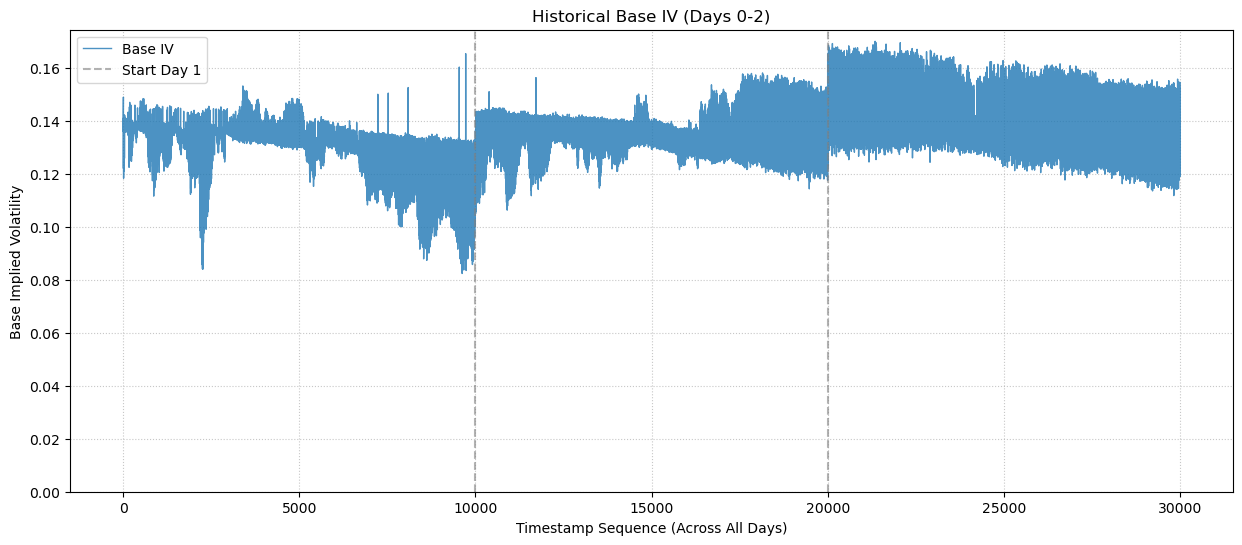

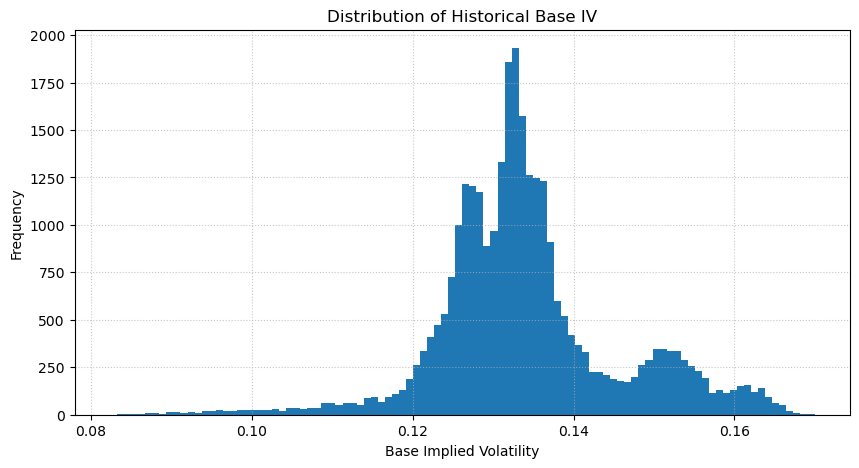


--- Basic Statistics for Base IV (Overall) ---
count    30000.000000
mean         0.134097
std          0.011350
min          0.082352
25%          0.127667
50%          0.132716
75%          0.137976
max          0.169955
Name: base_iv, dtype: float64

--- Average Base IV per Day ---
         mean       std       min       max
day                                        
0    0.130055  0.009886  0.082352  0.165319
1    0.133326  0.008590  0.104874  0.158025
2    0.138909  0.013225  0.111750  0.169955


In [23]:
# Step 1: Visualize Overall Base IV Behavior & Basic Stats

if not ts_df.empty:
    # --- Plot Base IV Time Series ---
    plt.figure(figsize=(15, 6))
    # Plotting against a simple sequence number for clarity across days
    plt.plot(np.arange(len(ts_df)), ts_df['base_iv'], label='Base IV', alpha=0.8, linewidth=1)
    # Add vertical lines for day changes - assumes timestamps are consecutive
    day_indices = ts_df.index.get_level_values('day')
    change_indices = np.where(day_indices[:-1] != day_indices[1:])[0] + 1
    for idx in change_indices:
         plt.axvline(idx, color='grey', linestyle='--', alpha=0.6, label=f'Start Day {day_indices[idx]}' if idx == change_indices[0] else "")

    plt.xlabel('Timestamp Sequence (Across All Days)')
    plt.ylabel('Base Implied Volatility')
    plt.title('Historical Base IV (Days 0-2)')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.ylim(bottom=0) # Volatility cannot be negative
    plt.show()

    # --- Plot Histogram ---
    plt.figure(figsize=(10, 5))
    ts_df['base_iv'].hist(bins=100)
    plt.title('Distribution of Historical Base IV')
    plt.xlabel('Base Implied Volatility')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()

    # --- Calculate Basic Statistics ---
    print("\n--- Basic Statistics for Base IV (Overall) ---")
    print(ts_df['base_iv'].describe())

    print("\n--- Average Base IV per Day ---")
    print(ts_df.groupby('day')['base_iv'].agg(['mean', 'std', 'min', 'max']))

else:
    print("`ts_df` is empty, cannot perform Step 1 analysis.")

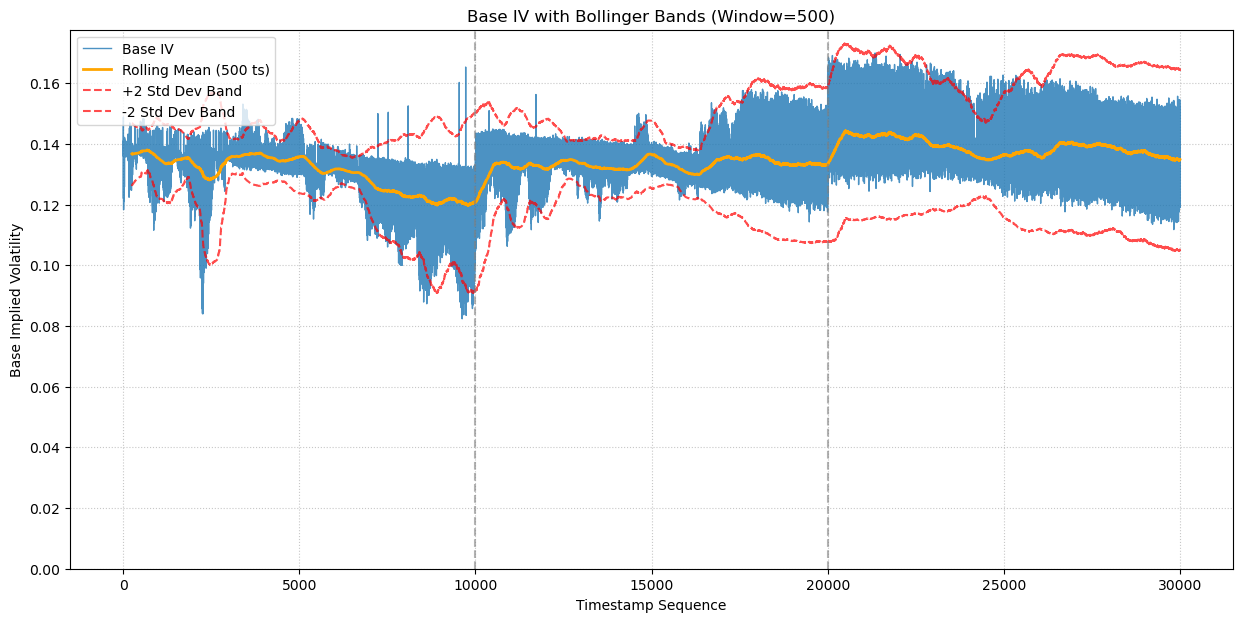

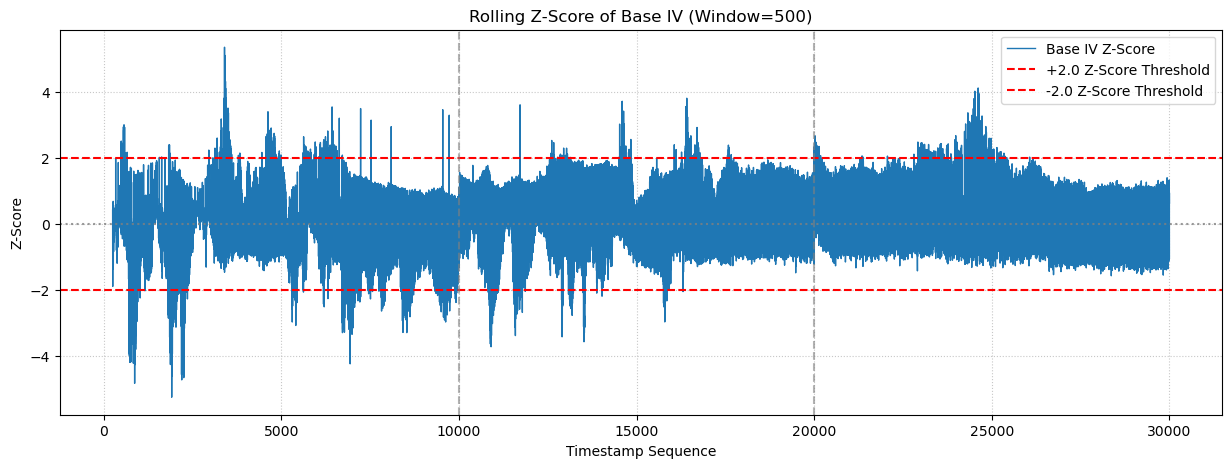


--- Z-Score Statistics ---
count    29751.000000
mean        -0.027563
std          1.058807
min         -5.262224
25%         -0.780156
50%         -0.207358
75%          0.799203
max          5.354409
Name: base_iv_zscore, dtype: float64
Percentage of time |Z-Score| > 2.0: 5.00%


In [25]:
# Step 3: Analyze Mean Reversion Tendencies (Base IV)

if not ts_df.empty:
    # --- Calculate Rolling Stats & Z-Score ---
    window = 500 # Example window size (e.g., 5 minutes if 100ms per timestamp) - TUNE THIS!
    ts_df['base_iv_roll_mean'] = ts_df['base_iv'].rolling(window=window, min_periods=window//2).mean() # Calculate rolling mean
    ts_df['base_iv_roll_std'] = ts_df['base_iv'].rolling(window=window, min_periods=window//2).std()   # Calculate rolling std dev

    # Avoid division by zero or small std dev
    ts_df['base_iv_zscore'] = (ts_df['base_iv'] - ts_df['base_iv_roll_mean']) / (ts_df['base_iv_roll_std'].replace(0, np.nan))

    # --- Plot Bollinger Bands ---
    plt.figure(figsize=(15, 7))
    x_axis = np.arange(len(ts_df)) # Use sequence for x-axis
    plt.plot(x_axis, ts_df['base_iv'], label='Base IV', alpha=0.8, linewidth=1)
    plt.plot(x_axis, ts_df['base_iv_roll_mean'], label=f'Rolling Mean ({window} ts)', color='orange', linewidth=2)
    plt.plot(x_axis, ts_df['base_iv_roll_mean'] + 2 * ts_df['base_iv_roll_std'], label='+2 Std Dev Band', color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    plt.plot(x_axis, ts_df['base_iv_roll_mean'] - 2 * ts_df['base_iv_roll_std'], label='-2 Std Dev Band', color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    # Add vertical lines for day changes
    day_indices = ts_df.index.get_level_values('day')
    change_indices = np.where(day_indices[:-1] != day_indices[1:])[0] + 1
    for idx in change_indices: plt.axvline(idx, color='grey', linestyle='--', alpha=0.6)

    plt.xlabel('Timestamp Sequence')
    plt.ylabel('Base Implied Volatility')
    plt.title(f'Base IV with Bollinger Bands (Window={window})')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.ylim(bottom=0)
    plt.show()

    # --- Plot Z-Score ---
    plt.figure(figsize=(15, 5))
    plt.plot(x_axis, ts_df['base_iv_zscore'], label='Base IV Z-Score', linewidth=1)
    # Add threshold lines (e.g., +/- 1.5 or 2.0)
    z_threshold = 2.0
    plt.axhline(z_threshold, color='red', linestyle='--', label=f'+{z_threshold} Z-Score Threshold')
    plt.axhline(-z_threshold, color='red', linestyle='--', label=f'-{z_threshold} Z-Score Threshold')
    plt.axhline(0, color='grey', linestyle=':', alpha=0.8)
    # Add vertical lines for day changes
    for idx in change_indices: plt.axvline(idx, color='grey', linestyle='--', alpha=0.6)

    plt.xlabel('Timestamp Sequence')
    plt.ylabel('Z-Score')
    plt.title(f'Rolling Z-Score of Base IV (Window={window})')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()

    print("\n--- Z-Score Statistics ---")
    print(ts_df['base_iv_zscore'].describe())
    print(f"Percentage of time |Z-Score| > {z_threshold}: {100 * (ts_df['base_iv_zscore'].abs() > z_threshold).mean():.2f}%")

else:
    print("`ts_df` is empty, cannot perform Step 3 analysis.")


Attempting to plot Volatility Smile for Day 1, Timestamp 200

Fitted Coefficients (a, b, c): [0.33304079 0.04832475 0.1362717 ]
Base IV (Implied Volatility at m=0 from fit): 0.1363


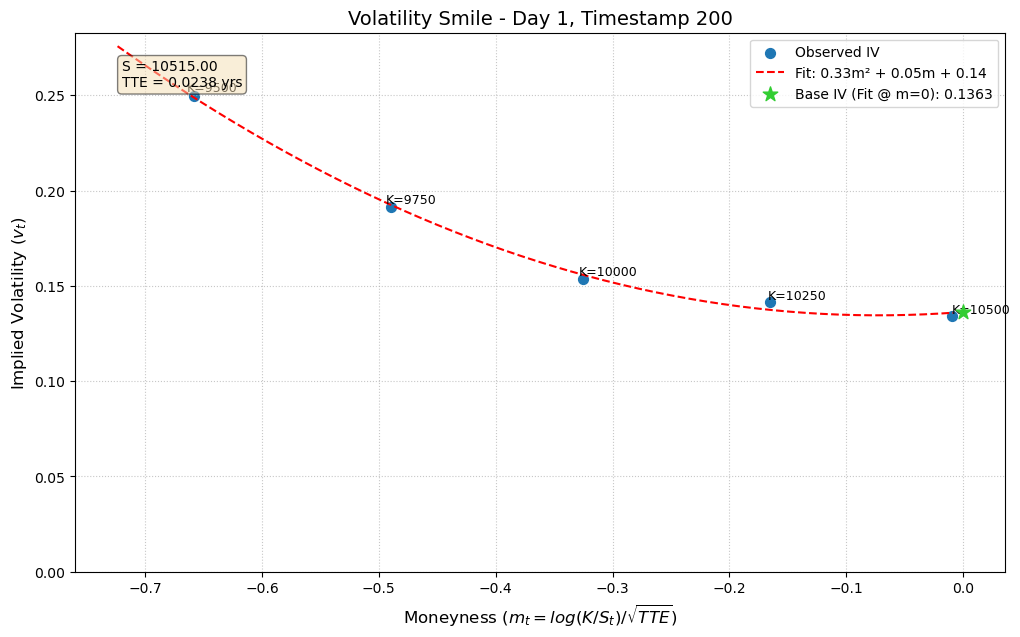

In [37]:
# Block to Plot Single Volatility Smile Example
# --- Choose Timestamp to Plot ---
example_day = 1
example_timestamp = 200 # Middle of Day 1 (or choose another existing timestamp)
example_index = (example_day, example_timestamp)

print(f"\nAttempting to plot Volatility Smile for Day {example_day}, Timestamp {example_timestamp}")

# Check if prerequisites exist
if 'df_pivot' not in locals() or df_pivot.empty:
     print("\nError: `df_pivot` DataFrame not found or is empty. Please run previous blocks first.")
elif not callable(globals().get('implied_volatility_bisect')):
     print("\nError: Helper function `implied_volatility_bisect` not defined. Please run Block 2.")
elif 'VOUCHERS' not in locals() or not isinstance(VOUCHERS, dict):
     print("\nError: `VOUCHERS` dictionary not defined. Please run Block 1.")
# Check if the chosen index exists
elif example_index not in df_pivot.index:
     print(f"\nError: Timestamp index {example_index} not found in `df_pivot`. Try a different timestamp.")
else:
    # --- Proceed with Plotting ---
    example_row = df_pivot.loc[example_index]
    S = example_row.get('S')
    T = example_row.get('TTE') # Get TTE for this specific row

    if pd.isna(S) or pd.isna(T) or S <= 0 or T <= 1e-9:
        print(f"Cannot plot: Invalid S ({S}) or TTE ({T}) at the selected timestamp.")
    else:
        plot_m = []
        plot_v = []
        plot_labels = []
        valid_points_count = 0

        # Calculate m_t, v_t for each voucher at this timestamp
        for voucher_name, K in VOUCHERS.items():
            voucher_col = f'V_{K}'
            if voucher_col not in example_row: continue

            V = example_row[voucher_col]
            if pd.isna(V) or V <= 0: continue

            try: m_val = math.log(K / S) / math.sqrt(T)
            except Exception: m_val = np.nan

            v_val = implied_volatility_bisect(S, K, RISK_FREE_RATE, T, V) # Call global function

            if pd.notna(m_val) and pd.notna(v_val) and np.isfinite(m_val) and np.isfinite(v_val) and v_val > 0:
                plot_m.append(m_val)
                plot_v.append(v_val)
                plot_labels.append(f'K={K}')
                valid_points_count +=1

        # Proceed with plotting if valid points found
        if valid_points_count > 0:
            plot_m = np.array(plot_m)
            plot_v = np.array(plot_v)

            plt.figure(figsize=(12, 7))
            plt.scatter(plot_m, plot_v, label='Observed IV', marker='o', s=50)

            for i, label in enumerate(plot_labels):
                plt.text(plot_m[i] * 1.01, plot_v[i] * 1.01, label, fontsize=9)

            if valid_points_count >= 3:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", np.RankWarning)
                    try:
                        coeffs = np.polyfit(plot_m, plot_v, 2)
                        poly = np.poly1d(coeffs)
                        a, b, c = coeffs
                        base_iv = c

                        m_fit_min = plot_m.min() - 0.1 * abs(plot_m.min()) if plot_m.size > 0 else -0.5
                        m_fit_max = plot_m.max() + 0.1 * abs(plot_m.max()) if plot_m.size > 0 else 0.5
                        m_fit = np.linspace(m_fit_min, m_fit_max, 200)
                        v_fit = poly(m_fit)

                        plt.plot(m_fit, v_fit, color='red', linestyle='--', label=f'Fit: {a:.2f}m² + {b:.2f}m + {c:.2f}')
                        plt.scatter([0], [base_iv], color='limegreen', s=120, zorder=5, marker='*', label=f'Base IV (Fit @ m=0): {base_iv:.4f}')
                        print(f"\nFitted Coefficients (a, b, c): {coeffs}")
                        print(f"Base IV (Implied Volatility at m=0 from fit): {base_iv:.4f}")

                    except Exception as e: print(f"Could not fit parabola: {e}")
            else: print("\nNot enough valid data points (need >= 3) to fit parabola.")

            # Using raw string r'...' for the xlabel
            plt.xlabel(r'Moneyness ($m_t = log(K/S_t) / \sqrt{TTE}$)', fontsize=12)
            plt.ylabel('Implied Volatility ($v_t$)', fontsize=12)
            plt.title(f'Volatility Smile - Day {example_day}, Timestamp {example_timestamp}', fontsize=14)
            plt.grid(True, linestyle=':', alpha=0.7)
            plt.legend()
            plt.ylim(bottom=0)
            textstr = f'S = {S:.2f}\nTTE = {T:.4f} yrs'
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=props)
            plt.show()

        else:
            print("\nNo valid (m_t, v_t) pairs found for the selected timestamp to plot.")

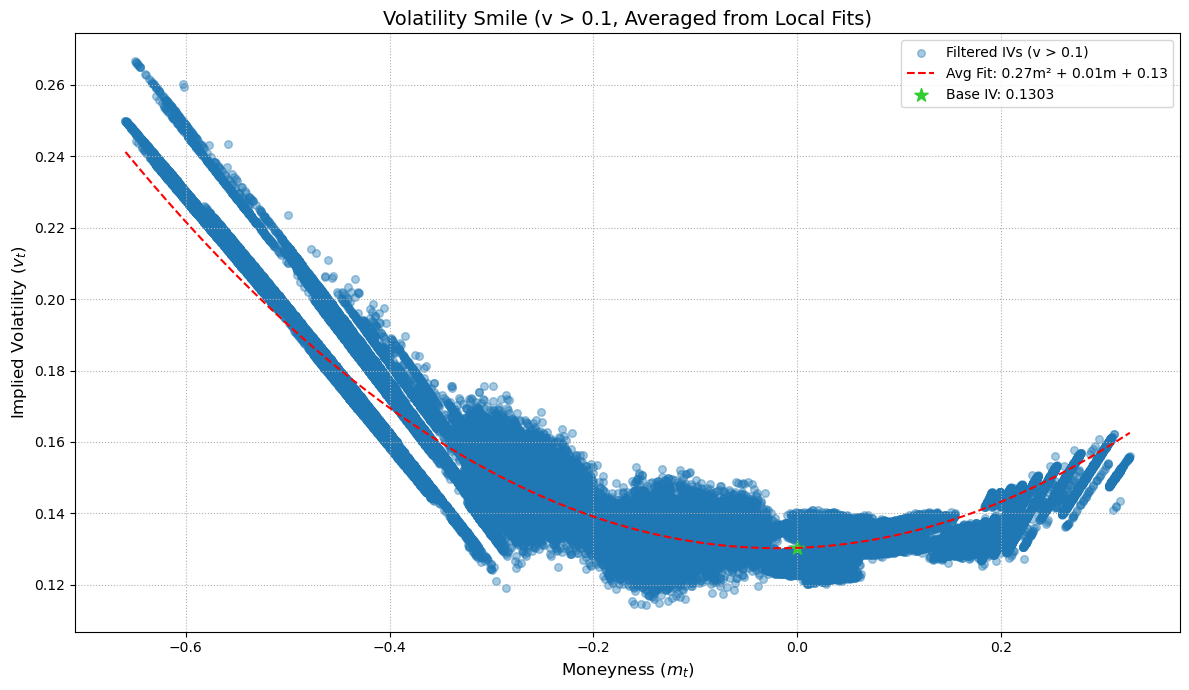


Averaged Coefficients (a, b, c): 0.2710, 0.0104, 0.1303


In [44]:
# Store fitted coefficients for each timestamp
coeff_list = []

for (day, timestamp), row in df_pivot.iterrows():
    S = row.get('S')
    T = row.get('TTE')

    if pd.isna(S) or pd.isna(T) or S <= 0 or T <= 1e-9:
        continue

    m_vals = []
    v_vals = []

    for voucher_name, K in VOUCHERS.items():
        col = f'V_{K}'
        if col not in row: continue
        V = row[col]
        if pd.isna(V) or V <= 0: continue

        try:
            m = math.log(K / S) / math.sqrt(T)
            v = implied_volatility_bisect(S, K, RISK_FREE_RATE, T, V)
        except: continue

        if np.isfinite(m) and np.isfinite(v) and v > 0.1:
            m_vals.append(m)
            v_vals.append(v)

    if len(m_vals) >= 3:
        try:
            coeffs = np.polyfit(m_vals, v_vals, 2)
            coeff_list.append(coeffs)
        except: continue

# Average the coefficients
if len(coeff_list) > 0:
    coeff_array = np.array(coeff_list)
    avg_coeffs = coeff_array.mean(axis=0)
    a, b, c = avg_coeffs
    base_iv = c

    # Plot all valid points again (filtered)
    all_m = []
    all_v = []

    for (day, timestamp), row in df_pivot.iterrows():
        S = row.get('S')
        T = row.get('TTE')

        if pd.isna(S) or pd.isna(T) or S <= 0 or T <= 1e-9:
            continue

        for voucher_name, K in VOUCHERS.items():
            col = f'V_{K}'
            if col not in row: continue
            V = row[col]
            if pd.isna(V) or V <= 0: continue

            try:
                m = math.log(K / S) / math.sqrt(T)
                v = implied_volatility_bisect(S, K, RISK_FREE_RATE, T, V)
            except: continue

            if np.isfinite(m) and np.isfinite(v) and v > 0.1:
                all_m.append(m)
                all_v.append(v)

    # Plot
    plt.figure(figsize=(12, 7))
    plt.scatter(all_m, all_v, alpha=0.4, s=30, label="Filtered IVs (v > 0.1)")

    m_fit = np.linspace(min(all_m), max(all_m), 300)
    poly = np.poly1d(avg_coeffs)
    plt.plot(m_fit, poly(m_fit), 'r--', label=f'Avg Fit: {a:.2f}m² + {b:.2f}m + {c:.2f}')
    plt.scatter([0], [base_iv], color='limegreen', s=100, marker='*', label=f'Base IV: {base_iv:.4f}')

    plt.title("Volatility Smile (v > 0.1, Averaged from Local Fits)", fontsize=14)
    plt.xlabel(r'Moneyness ($m_t$)', fontsize=12)
    plt.ylabel('Implied Volatility ($v_t$)', fontsize=12)
    plt.grid(True, linestyle=':')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"\nAveraged Coefficients (a, b, c): {a:.4f}, {b:.4f}, {c:.4f}")
else:
    print("Not enough valid data (v > 0.1) to generate average fit.")



--- Analyzing Historical Relative Value Spreads ---
Calculating historical spreads (v_actual - v_fitted)...
  Processed 5000/30000 timestamps for spreads...
  Processed 10000/30000 timestamps for spreads...
  Processed 15000/30000 timestamps for spreads...
  Processed 20000/30000 timestamps for spreads...
  Processed 25000/30000 timestamps for spreads...
  Processed 30000/30000 timestamps for spreads...
Finished calculating spreads. Encountered 453 calculation issues (skipped).

--- Spread Statistics and Thresholds ---

Strike 9500:
  Count: 29599
  Mean Spread: -0.005178
  Std Dev Spread: 0.012942
  Threshold (+/- 1.5*StdDev): 0.019413

Strike 9750:
  Count: 29948
  Mean Spread: 0.011359
  Std Dev Spread: 0.031282
  Threshold (+/- 1.5*StdDev): 0.046922

Strike 10000:
  Count: 30000
  Mean Spread: -0.002637
  Std Dev Spread: 0.015791
  Threshold (+/- 1.5*StdDev): 0.023686

Strike 10250:
  Count: 30000
  Mean Spread: -0.008316
  Std Dev Spread: 0.013874
  Threshold (+/- 1.5*StdDev): 0.

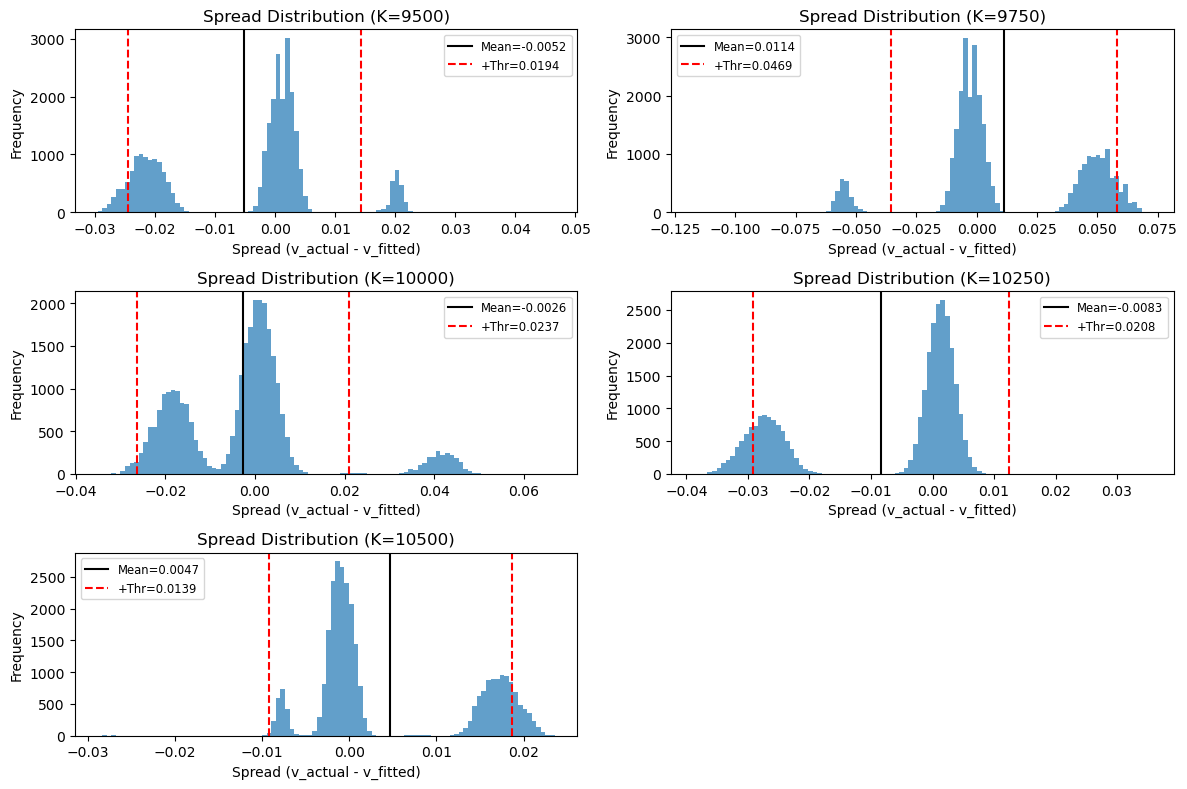


Calculated Thresholds Dictionary:
{9500: 0.019412553125190392, 9750: 0.046922372661094405, 10000: 0.02368642667489272, 10250: 0.020811463719388586, 10500: 0.01389791277213679}


In [45]:
# Block to Analyze Historical Relative Value Spreads (v_actual - v_fitted)

print("\n--- Analyzing Historical Relative Value Spreads ---")

# Check if prerequisites exist
if 'df_pivot' not in locals() or df_pivot.empty:
     print("Error: `df_pivot` DataFrame not found or is empty.")
elif 'ts_df' not in locals() or ts_df.empty:
     print("Error: `ts_df` DataFrame not found or is empty.")
elif not callable(globals().get('implied_volatility_bisect')):
     print("Error: Helper function `implied_volatility_bisect` not defined.")
elif 'VOUCHERS' not in locals() or not isinstance(VOUCHERS, dict):
     print("Error: `VOUCHERS` dictionary not defined.")
else:
    # Merge the coefficients from ts_df into df_pivot for easier access
    # We only need 'coeff_a', 'coeff_b', 'base_iv' (which is 'c')
    df_merged = df_pivot.join(ts_df[['coeff_a', 'coeff_b', 'base_iv']])

    # Drop rows where the parabola fit failed (coeffs are NaN)
    # Note: Your previous output showed 0 NaNs, so this might not drop anything, but it's good practice
    initial_rows = len(df_merged)
    df_merged.dropna(subset=['coeff_a', 'coeff_b', 'base_iv'], inplace=True)
    if initial_rows > len(df_merged):
         print(f"Dropped {initial_rows - len(df_merged)} rows where parabola fit failed.")

    # Initialize dictionary to store spreads for each strike
    historical_spreads = {K: [] for K in VOUCHERS.values()}

    print("Calculating historical spreads (v_actual - v_fitted)...")
    calculation_errors = 0
    processed_count = 0

    # Iterate through timestamps where fit was successful
    for index, row in df_merged.iterrows():
        S = row.get('S')
        T = row.get('TTE')
        a = row.get('coeff_a')
        b = row.get('coeff_b')
        c = row.get('base_iv') # c is the base_iv

        # Should already be checked by dropna, but double-check
        if pd.isna(S) or pd.isna(T) or pd.isna(a) or pd.isna(b) or pd.isna(c) or T <= 1e-9 or S <= 0:
            continue

        # Calculate spread for each voucher
        for voucher_name, K in VOUCHERS.items():
            voucher_col = f'V_{K}'
            if voucher_col not in row: continue
            V = row[voucher_col]
            if pd.isna(V) or V <= 0: continue

            # Recalculate m_t and v_t (actual)
            try: m_t = math.log(K / S) / math.sqrt(T)
            except Exception: m_t = np.nan
            v_t = implied_volatility_bisect(S, K, RISK_FREE_RATE, T, V)

            if pd.notna(m_t) and pd.notna(v_t) and np.isfinite(m_t) and np.isfinite(v_t) and v_t > 0:
                # Calculate fitted volatility
                v_fitted = a * (m_t**2) + b * m_t + c
                spread = v_t - v_fitted
                historical_spreads[K].append(spread)
            else:
                 calculation_errors += 1

        processed_count += 1
        if processed_count % 5000 == 0:
            print(f"  Processed {processed_count}/{len(df_merged)} timestamps for spreads...")

    print(f"Finished calculating spreads. Encountered {calculation_errors} calculation issues (skipped).")

    # --- Analyze Spread Distributions and Set Thresholds ---
    print("\n--- Spread Statistics and Thresholds ---")
    spread_thresholds = {}
    std_dev_multiplier = 1.5 # How many std devs for threshold - TUNE THIS!

    plt.figure(figsize=(12, 8))
    plot_index = 1
    num_strikes = len(historical_spreads)

    for K, spreads in historical_spreads.items():
        if len(spreads) > 1: # Need at least 2 points for std dev
            spreads_np = np.array(spreads)
            mean_spread = np.mean(spreads_np)
            std_dev_spread = np.std(spreads_np)
            threshold = std_dev_multiplier * std_dev_spread
            spread_thresholds[K] = threshold # Store threshold for this strike

            print(f"\nStrike {K}:")
            print(f"  Count: {len(spreads)}")
            print(f"  Mean Spread: {mean_spread:.6f}")
            print(f"  Std Dev Spread: {std_dev_spread:.6f}")
            print(f"  Threshold (+/- {std_dev_multiplier}*StdDev): {threshold:.6f}")

            # Optional: Plot histogram
            ax = plt.subplot(math.ceil(num_strikes / 2), 2, plot_index)
            ax.hist(spreads_np, bins=100, alpha=0.7)
            ax.axvline(mean_spread, color='black', linestyle='-', label=f'Mean={mean_spread:.4f}')
            ax.axvline(mean_spread + threshold, color='red', linestyle='--', label=f'+Thr={threshold:.4f}')
            ax.axvline(mean_spread - threshold, color='red', linestyle='--')
            ax.set_title(f'Spread Distribution (K={K})')
            ax.set_xlabel('Spread (v_actual - v_fitted)')
            ax.set_ylabel('Frequency')
            ax.legend(fontsize='small')
            plot_index += 1

        else:
            print(f"\nStrike {K}: Not enough data points ({len(spreads)}) to calculate stats.")
            spread_thresholds[K] = np.nan # Indicate threshold couldn't be set

    plt.tight_layout()
    plt.show()

    print("\nCalculated Thresholds Dictionary:")
    print(spread_thresholds)
    # You would store 'spread_thresholds' (or derived values) to use in your Trader class.